In [1]:
import os
# Get the current working directory
current_dir = os.getcwd()
# Get the parent directory
parent_dir = os.path.dirname(current_dir)
# Change the working directory to the parent directory
os.chdir(parent_dir)

In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
qaoa_64 = {i/10 : [] for i in range(1, 11)}
qaoa_star_64 = {i/10 : [] for i in range(1, 11)}
rqaoa_64 = {i/10 : [] for i in range(1, 11)}
rqaoa_star_64 = {i/10 : [] for i in range(1, 11)}

num_vertices = 64
P_INDICES = range(1, 11)

for p in P_INDICES:
    for i in P_INDICES:

        graph_path = f"graphs/G{num_vertices}_{p}_{i}.gpickle"
        result_path = f"sim_results/G{num_vertices}_{p}_{i}.pkl"

        with open(graph_path, "rb") as f:
            graph = pickle.load(f)
        with open(result_path, "rb") as f:
            result_dict = pickle.load(f)
            
        num_edges = graph.number_of_edges()

        qaoa_64[p/10].append(result_dict['QAOA'] / num_edges)
        qaoa_star_64[p/10].append(result_dict['QAOA*'] / num_edges)
        rqaoa_64[p/10].append(result_dict['RQAOA'] / num_edges)
        rqaoa_star_64[p/10].append(result_dict['RQAOA*'] / num_edges)

In [4]:
qaoa_128 = {i/10 : [] for i in range(1, 11)}
qaoa_star_128 = {i/10 : [] for i in range(1, 11)}
rqaoa_128 = {i/10 : [] for i in range(1, 11)}
rqaoa_star_128 = {i/10 : [] for i in range(1, 11)}

num_vertices = 128
P_INDICES = range(1, 11)

for p in P_INDICES:
    for i in P_INDICES:

        graph_path = f"graphs/G{num_vertices}_{p}_{i}.gpickle"
        result_path = f"sim_results/G{num_vertices}_{p}_{i}.pkl"

        with open(graph_path, "rb") as f:
            graph = pickle.load(f)
        with open(result_path, "rb") as f:
            result_dict = pickle.load(f)
            
        num_edges = graph.number_of_edges()

        qaoa_128[p/10].append(result_dict['QAOA'] / num_edges)
        qaoa_star_128[p/10].append(result_dict['QAOA*'] / num_edges)
        rqaoa_128[p/10].append(result_dict['RQAOA'] / num_edges)
        rqaoa_star_128[p/10].append(result_dict['RQAOA*'] / num_edges)

In [5]:
# ---------- 1) Data helpers -------------------------------------------------
def dicts_to_df(qaoa, qaoa_star, rqaoa, rqaoa_star, n_label):
    """Build a long-form DataFrame from four {p: [values...]} dicts for a given n."""
    rows = []
    for algo, d in [
        ("QAOA",   qaoa),
        ("QAOA*",  qaoa_star),
        ("RQAOA",  rqaoa),
        ("RQAOA*", rqaoa_star),
    ]:
        for p, values in d.items():
            for v in values:
                rows.append({"n": int(n_label), "p": float(p), "algo": algo, "AR": float(v)})
    return pd.DataFrame(rows)

In [6]:
# ---------- 2) Plotting (one function) -------------------------------------
def plot_ar_bars(
    df,
    filename_pdf,
    figsize=(6.8, 4.2),
    palette=None,
    show_legend=True,
    ylabel="Approximation Ratio (AR)",
):
    """
    Make a compact grouped bar plot of Approximation Ratio by p and algo.
    Saves the figure as a PDF (and returns fig, ax).
    """
    if palette is None:
        # light, print-friendly, colorblind-friendly
        palette = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#FB9A99"]

    sns.set_theme(style="whitegrid", context="notebook")

    p_order = sorted(df["p"].unique())
    fig, ax = plt.subplots(figsize=figsize, dpi=120)

    # Seaborn 0.12+ uses errorbar=, older uses ci=
    barplot_kwargs = dict(
        data=df, x="p", y="AR", hue="algo",
        order=p_order, estimator=np.mean,
        capsize=0.12, dodge=True, palette=palette,
        edgecolor="black", linewidth=0.9, width=0.80, ax=ax,
        legend=show_legend,   # ignored on older Seaborn (we handle below)
    )
    try:
        sns.barplot(errorbar="sd", **barplot_kwargs, err_kws={'linewidth': 1.2, 'color': 'black'})
    except TypeError:
        sns.barplot(ci="sd", **barplot_kwargs)

    # --- Axes labels, ticks, limits
    ax.set_xlabel("Probability (p)", fontsize=12)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12)
    else:
        ax.set_ylabel(None)
    ax.set_ylim(0, 1.02)
    ax.set_yticks(np.arange(0, 1.01, 0.1))
    ax.tick_params(axis="both", labelsize=10, length=4, width=1, color="black")

    # --- Spines & tick positions
    for sp in ("top", "right", "left", "bottom"):
        ax.spines[sp].set_visible(True)
        ax.spines[sp].set_linewidth(1.0)
        ax.spines[sp].set_color("black")
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")

    # --- Legend handling (robust across versions)
    if not show_legend:
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()
    else:
        leg = ax.legend(
            loc="lower right",
            frameon=True, framealpha=0.9,
            facecolor="white", edgecolor="#CCCCCC",
            fontsize=9, ncol=2, columnspacing=1.0, handlelength=1.2,
            title=None,
        )

    fig.tight_layout()

    # --- Save
    fig.savefig(filename_pdf, bbox_inches="tight")
    # Optional PNG (comment out if not needed)
    # fig.savefig(filename_pdf.replace(".pdf", ".png"), dpi=300, bbox_inches="tight")

    return fig, ax

In [7]:
df64  = dicts_to_df(qaoa_64,  qaoa_star_64,  rqaoa_64,  rqaoa_star_64,  64)
df128 = dicts_to_df(qaoa_128, qaoa_star_128, rqaoa_128, rqaoa_star_128, 128)

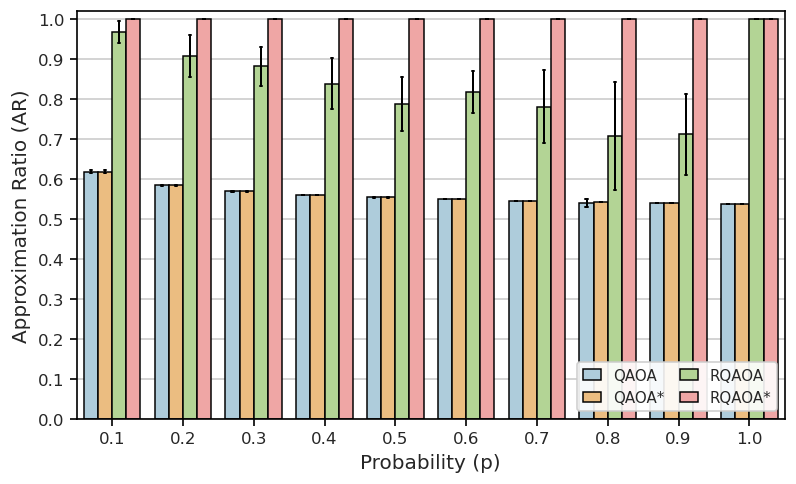

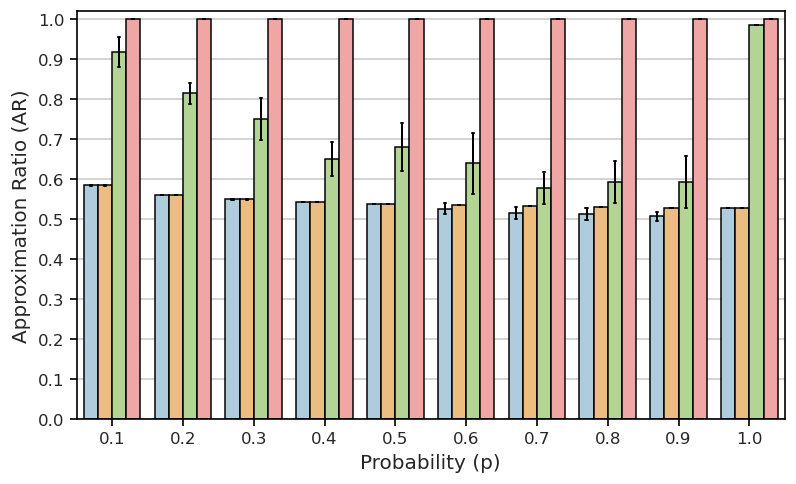

In [8]:
_ = plot_ar_bars(df64,  filename_pdf="results_unweighted_n64.pdf")
_ = plot_ar_bars(df128, filename_pdf="results_unweighted_n128.pdf", show_legend=False)